# EDA and Cleaning

## Introduction

### Summary
This project aimes to recognize the topics Small Business Owners and Startup owners discuss about on Reddit, their similarities, and differences. The results are targeted towards a Financial Institution, that is starting a new blog to attract companies at small size. This research investigates in what these two gruops differ for interest, and whether it might make sense to address them together or separately.


### In this Notebook
In this notebook I perform basic exploratory data analysis and consequential data cleaning.

In particular I start by handling nulls, deleted posts and in general and removed ones.

Then I decide to create a `alltext` feature, combining `title` and `subtext`.

Also, I investigate potential differences in **engagement** for the two subreddits, starting with *comments* and moving on to *word count* and *post_lenght*. If I wold have find any significant difference or peculiarity I would have engineered features describing it; unfortunately the two subreddits look extremely similar.

Then, to prepare my data for the modeling, I clean the text data using RegEx and lemmatize it.

I decide to store the entirety of my text in the same columns, to reduce the potential confusion of handling too many features and keep my code and data as clean and clear as possible.

At the end I export the dataframe as `corpus_clean.csv`, ready to be processed in the next notebook.



### Notebook Index

- [01 | Data Collection](01_data_collection.ipynb)
- [02 | EDA & Cleaning](02_eda.ipynb)
- [03 | Model](03_model.ipynb)
- [04 | Sentiment Analysis](04_sentiment_analysis.ipynb)

## 1. Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import text

The following is a custom function that sets a custom palette and shows it for further reference.

In [66]:
def custom_pallete(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

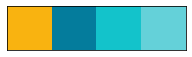

In [138]:
acqua = ["#84B099","#973276","#CA8D89", "#E4F3E0","#B5DEC8","#9CC7B0","#84B099","#CFB384","#F7BF7D","#CA8D89","#8959B9","#973276"]
contrast =["#E26D5C","#FFCD70", "#38618C", '#723D46', '#472D30']
project_3 = ["#F9B310","#047C9C","#13C3CB", "#64D1D9"]
custom_pallete(project_3)

In [4]:
df = pd.read_csv('../data/corpus.csv')

In [5]:
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self
0,Gusto problems?,NaN,smallbusiness,1610069013,[deleted],0,1,True
1,what would be the best way of calling potentia...,[removed],smallbusiness,1610069951,wilsonckao,2,1,True
2,GURUS VS BOOKS,[removed],smallbusiness,1610069955,Alpha12x,0,1,True
3,Is there a way to spread out a windfall income...,If my business suddenly brings in a thousand t...,smallbusiness,1610070146,if_yes_else_no,5,1,True
4,EIDL/PPP Credit Denials A Thing?,I’m just today hearing from my Friend that bot...,smallbusiness,1610070921,WildFireBrand,3,1,True


## 2. Cleaning

I notce that many posts are marked as [removed] or [deleted] in selftext. I decide to drop those, as they are often spam.

In [6]:
df['selftext'] = df['selftext'].map(lambda x: np.nan if x == '[removed]' or x == 'nan' or x == '[deleted]' else str(x))

In [8]:
df = df.dropna(subset = ['selftext'])

In [9]:
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self
0,Gusto problems?,nan,smallbusiness,1610069013,[deleted],0,1,True
3,Is there a way to spread out a windfall income...,If my business suddenly brings in a thousand t...,smallbusiness,1610070146,if_yes_else_no,5,1,True
4,EIDL/PPP Credit Denials A Thing?,I’m just today hearing from my Friend that bot...,smallbusiness,1610070921,WildFireBrand,3,1,True
5,I'd like to learn about getting clientele with...,I'm broke due to this pandemic. Like lost ever...,smallbusiness,1610071223,OneBase,30,2,True
7,Owning two separate businesses while using the...,I am thinking about starting up a different LL...,smallbusiness,1610072846,TheFourthSon,17,1,True


In [10]:
df.isnull().sum()

title           0
selftext        0
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
dtype: int64

Verified that I do not have any more Nulls in my data I check the shape.

In [11]:
df.shape

(11929, 8)

Veryfied that I have 11929 rows to work with, having exclude the empty `'selftext'` rows, I proceed veryfing the number of posts I have for each subreddit.

In [12]:
df['subreddit'].value_counts()

smallbusiness    7406
startups         4523
Name: subreddit, dtype: int64

Small business sample size is bigger than startups, but both seem large enough to continue with the analysis.

### Consolidate Text

I decide to combine title and selftext in a unique feature. This is bcecause many questions seems to start from the title and I want to maximize the amount of text I will work on.

In [15]:
df['alltext'] = df['title'] + ' ' + df['selftext']

In [16]:
df = df.drop(columns = 'selftext')

### Target

I want to predict 'subreddit', so I modify the current `subreddit` feature into `target` and set startups = 1, smallbusiness = 0.

In [17]:
df['target'] = df['subreddit'].map({'startups': 1, 'smallbusiness': 0})
df.drop('subreddit', axis=1, inplace=True)
df.head()

,title,created_utc,author,num_comments,score,is_self,alltext,target
0,Gusto problems?,1610069013,[deleted],0,1,True,Gusto problems? nan,0
3,Is there a way to spread out a windfall income...,1610070146,if_yes_else_no,5,1,True,Is there a way to spread out a windfall income...,0
4,EIDL/PPP Credit Denials A Thing?,1610070921,WildFireBrand,3,1,True,EIDL/PPP Credit Denials A Thing? I’m just toda...,0
5,I'd like to learn about getting clientele with...,1610071223,OneBase,30,2,True,I'd like to learn about getting clientele with...,0
7,Owning two separate businesses while using the...,1610072846,TheFourthSon,17,1,True,Owning two separate businesses while using the...,0


### Text Cleaning

The following function accepts a string of text and, after turnin it lowercase, uses RegEx to clean it from whitespaces, special characters, hyperlinks and punctuations. I also decided to remove all words of 2 or less charcters.

This function was inspired by stackoverflow https://stackoverflow.com/questions/55187374/cleaning-text-with-python-and-re

In [18]:
def cleaner(txt):
    """cleaner accepts a string"""
    # Make lowercase
    txt = txt.lower()

    # Handle formatting characters (e.g. &amp)
    txt = re.sub(r'\&\w*;', '', txt)
    
    # Delete whitespaces
    txt = re.sub(r'\s\s+', ' ', txt)
    
    # Exclude hyperlinks
    txt = re.sub(r'https?:\/\/.*\/\w*', '', txt)
    
    # Handle punctuation and 's, 't, 've 
    txt = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', txt)
    
    # Delete words less than 2 letters
    txt = re.sub(r'\b\w{1,2}\b', '', txt)
    
    # Remove characters outside Unicode:
    txt = ''.join(l for l in txt if l <= '\uFFFF')
    
    return txt

In [19]:
df['alltext'] = df['alltext'].apply(cleaner)

### Lemmatize

I create a function to lemmatize the words in the cleaned text, and store it back into a string.

I decided for this approach after having read many blogs and stackoverflow posts.

In [20]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(txt):
    """lemmatize words accepts a string"""
    words = txt.split()
    lem_words = ''
    for word in words:
        lem_words += (lemmatizer.lemmatize(word) + ' ')
    return lem_words

In [21]:
df['alltext'] = df['alltext'].apply(lemmatize_words)

In [22]:
df.shape

(11929, 8)

In [23]:
df = df.reset_index(drop=True)

In [24]:
df.isnull().sum()

title           0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
alltext         0
target          0
dtype: int64

## 3. Feature Engineering
For my feature engineering I investigate engagement in the two subreddits.
### Comments

In [13]:
(df['num_comments']).groupby(df['subreddit']).describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
smallbusiness,7406.0,10.675263,20.056605,0.0,2.0,5.0,11.0,425.0
startups,4523.0,12.445722,29.673758,0.0,2.0,5.0,13.0,692.0


Both samples seems to behave similarly: the average number of comment for posts in both subreddits is a little over 10, and, even if the largest amount of comments is a little higher for startups (692) than small business (425), they are clearly both outliers, and not significant for a feature to be included.

### Post Lenght

In [139]:
df['post_lenght'] = df['alltext'].str.len()

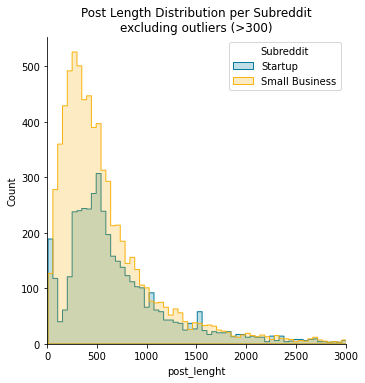

In [144]:
g = sns.displot(df, x="post_lenght", hue="target", legend=False, element="step")
plt.xlim(-1,3000)
plt.title("Post Length Distribution per Subreddit\nexcluding outliers (>300)")
plt.legend(title='Subreddit', loc='upper right', labels=['Startup', 'Small Business'])
plt.show(g)

The post length distribution is extreamely similar across the two subreddits, and the overlap seems too much for an additional feature to add meaning to the model.

### Word Count

In [140]:
df['post_word_count'] = df['alltext'].str.split().str.len()

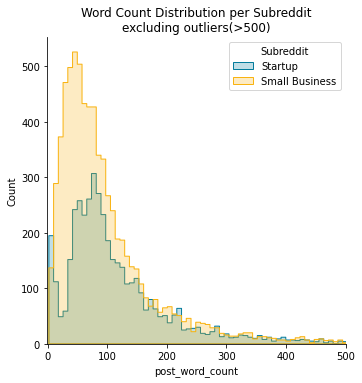

In [141]:
g = sns.displot(df, x="post_word_count", hue="target", legend=False, element="step")
plt.xlim(-1,500)
plt.title("Word Count Distribution per Subreddit\nexcluding outliers(>500)")
plt.legend(title='Subreddit', loc='upper right', labels=['Startup', 'Small Business'])
plt.show(g)

Same as per the post length, also the word count appears to be extremely similar and, even if **Startups** seems to be having lower word count, it does not appear to be a significantly different, to inform a better predictive model.

### Most common words

To investigate further the content of the text, I run the text through a custo function, to identify common words.
This uses count vectorizer and return a list of the most common n words.

In [26]:
def common_words(i, n_words, stopwords):
    """Get the most frequent *n* words
    in the 'alltext' feature for 'target' equal 0 or 1.
    """
    count_vect = CountVectorizer(analyzer = "word", 
                                 tokenizer = None, 
                                 preprocessor = None,
                                 stop_words = stopwords, 
                                 max_features = n_words) 

    # select input for CVectorizer
    vector_input = df[df['target'] == i]['alltext']

    # fit_transform the vectorizer
    words = count_vect.fit_transform(vector_input)

    # convert output to a Numpy array
    words = words.toarray()
    return  count_vect.get_feature_names()

In [27]:
startup_words = common_words(1, 40, 'english')

In [29]:
smb_words = common_words(0, 40, 'english')

In [28]:
print(startup_words)

['app', 'business', 'company', 'customer', 'don', 'feedback', 'founder', 'good', 'ha', 'help', 'idea', 'just', 'know', 'like', 'looking', 'make', 'marketing', 'money', 'month', 'need', 'new', 'people', 'product', 'question', 'really', 'service', 'start', 'startup', 'thing', 'think', 'time', 'use', 'user', 'wa', 'want', 'way', 'website', 'work', 'working', 'year']


In [30]:
print(smb_words)

['advice', 'business', 'client', 'company', 'customer', 'day', 'don', 'employee', 'good', 'ha', 'help', 'idea', 'just', 'know', 'like', 'looking', 'make', 'money', 'month', 'need', 'new', 'owner', 'people', 'product', 'question', 'really', 'sale', 'service', 'small', 'start', 'thanks', 'thing', 'time', 'use', 'wa', 'want', 'way', 'website', 'work', 'year']


From running this function I notice that:

- `x200b` value is a formatting feature, that I will add to stop_words.

- `don` is a residual from "don't" that I will also add to stopwords.

In [31]:
text.ENGLISH_STOP_WORDS

add_stop_words = ['don', 'x200b']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [32]:
startup_words = common_words(1, 40, stop_words)
print(startup_words)

['app', 'business', 'company', 'customer', 'experience', 'feedback', 'founder', 'free', 'good', 'help', 'idea', 'know', 'like', 'looking', 'make', 'marketing', 'money', 'month', 'need', 'new', 'people', 'post', 'product', 'question', 'really', 'service', 'start', 'startup', 'team', 'thing', 'think', 'time', 'use', 'user', 'want', 'way', 'website', 'work', 'working', 'year']


In [140]:
smb_words = common_words(0, 40, stop_words)
print(smb_words)

['advice', 'business', 'client', 'company', 'customer', 'day', 'employee', 'good', 'help', 'idea', 'know', 'like', 'looking', 'make', 'money', 'month', 'need', 'new', 'online', 'owner', 'pay', 'people', 'product', 'question', 'really', 'sale', 'service', 'small', 'start', 'tax', 'thanks', 'thing', 'think', 'time', 'use', 'want', 'way', 'website', 'work', 'year']


Between the two subreddits I recognize some common words and some specific words. This shows me that I still have to be mindful of the big overlap of these conversations, but also suggests that keywords could inform models and help predict better the terget.

In particular it is interesting to highlight that Startups refer to HR issues using the words `team`, `people`, and Small Business with `employee`.

## 4. Export Dataframe

In [25]:
df.to_csv('../data/corpus_clean.csv', index=False)